# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "4n_0m_4f_230330_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [60, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 32428
Frames resolution: 1080 x 1920


In [6]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [7]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4
1,1,0,71.000000,180.000000,75.018802,167.453360,NaN,60.841087,180.036849,NaN,60.841087,180.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4
2,2,0,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4
3,3,0,1688.654083,946.185121,1688.350248,926.874967,NaN,1688.654083,946.185121,NaN,1688.654083,946.185121,-0.328264,6331.0,284.882246,77.154991,0.962627,4
4,0,3,111.032926,209.754714,126.242099,193.086434,NaN,111.032926,209.754714,NaN,111.032926,209.754714,-0.041526,10873.0,421.613516,193.485567,0.888479,3
5,1,3,71.197321,148.875893,66.010553,163.113589,NaN,71.197321,148.875893,NaN,71.197321,148.875893,-0.262120,1120.0,120.148057,42.105351,0.936583,3
6,2,3,1690.291145,943.651682,1690.772174,924.596085,NaN,1690.291145,943.651682,NaN,1690.291145,943.651682,-0.338259,6629.0,284.008046,76.988740,0.962557,3
7,0,6,107.238138,203.509194,120.349567,188.989748,NaN,107.238138,203.509194,NaN,107.238138,203.509194,-0.014870,12182.0,412.730219,190.135245,0.887568,2


In [8]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3, 4])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2],
        tracking_0["orientation"].values[3]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         4   110.841087   61.000000     1.315672
1   1     0         4    71.000000  180.000000    -0.038240
2   2     0         4   110.841087  361.036849    -0.038240
3   3     0         4  1688.654083  946.185121    -0.328264


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4
1,1,0,71.000000,180.000000,75.018802,167.453360,NaN,60.841087,180.036849,NaN,60.841087,180.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4
2,2,0,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4
3,3,0,1688.654083,946.185121,1688.350248,926.874967,NaN,1688.654083,946.185121,NaN,1688.654083,946.185121,-0.328264,6331.0,284.882246,77.154991,0.962627,4
4,0,3,111.032926,209.754714,126.242099,193.086434,NaN,111.032926,209.754714,NaN,111.032926,209.754714,-0.041526,10873.0,421.613516,193.485567,0.888479,3
5,1,3,71.197321,148.875893,66.010553,163.113589,NaN,71.197321,148.875893,NaN,71.197321,148.875893,-0.262120,1120.0,120.148057,42.105351,0.936583,3
6,2,3,1690.291145,943.651682,1690.772174,924.596085,NaN,1690.291145,943.651682,NaN,1690.291145,943.651682,-0.338259,6629.0,284.008046,76.988740,0.962557,3
7,0,6,107.238138,203.509194,120.349567,188.989748,NaN,107.238138,203.509194,NaN,107.238138,203.509194,-0.014870,12182.0,412.730219,190.135245,0.887568,2
8,1,6,1690.399447,943.909356,1691.280739,924.047329,NaN,1690.399447,943.909356,NaN,1690.399447,943.909356,-0.339091,6509.0,287.576538,76.971310,0.963515,2


In [9]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
3731,3,32421,1677.215492,983.762765,1678.237616,972.161390,NaN,1677.215492,983.762765,NaN,1677.215492,983.762765,-0.411918,5151.0,136.313694,77.556910,0.822366,4
3732,0,32424,109.132969,52.775956,113.624287,59.256884,NaN,109.132969,52.775956,NaN,109.132969,52.775956,1.170787,549.0,135.037512,61.050870,0.891966,4
3733,1,32424,57.480791,166.665622,62.442537,174.386808,NaN,57.480791,166.665622,NaN,57.480791,166.665622,0.172136,6065.0,265.468800,113.285185,0.904376,4
3734,2,32424,1382.716031,165.754004,1387.550030,170.527763,NaN,1382.716031,165.754004,NaN,1382.716031,165.754004,1.127970,12114.0,232.339862,90.164408,0.921629,4
3735,3,32424,1677.335598,983.746700,1678.699476,971.550937,NaN,1677.335598,983.746700,NaN,1677.335598,983.746700,-0.413642,5152.0,137.254149,77.491081,0.825378,4


## Velocities distribution in each frame

In [10]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


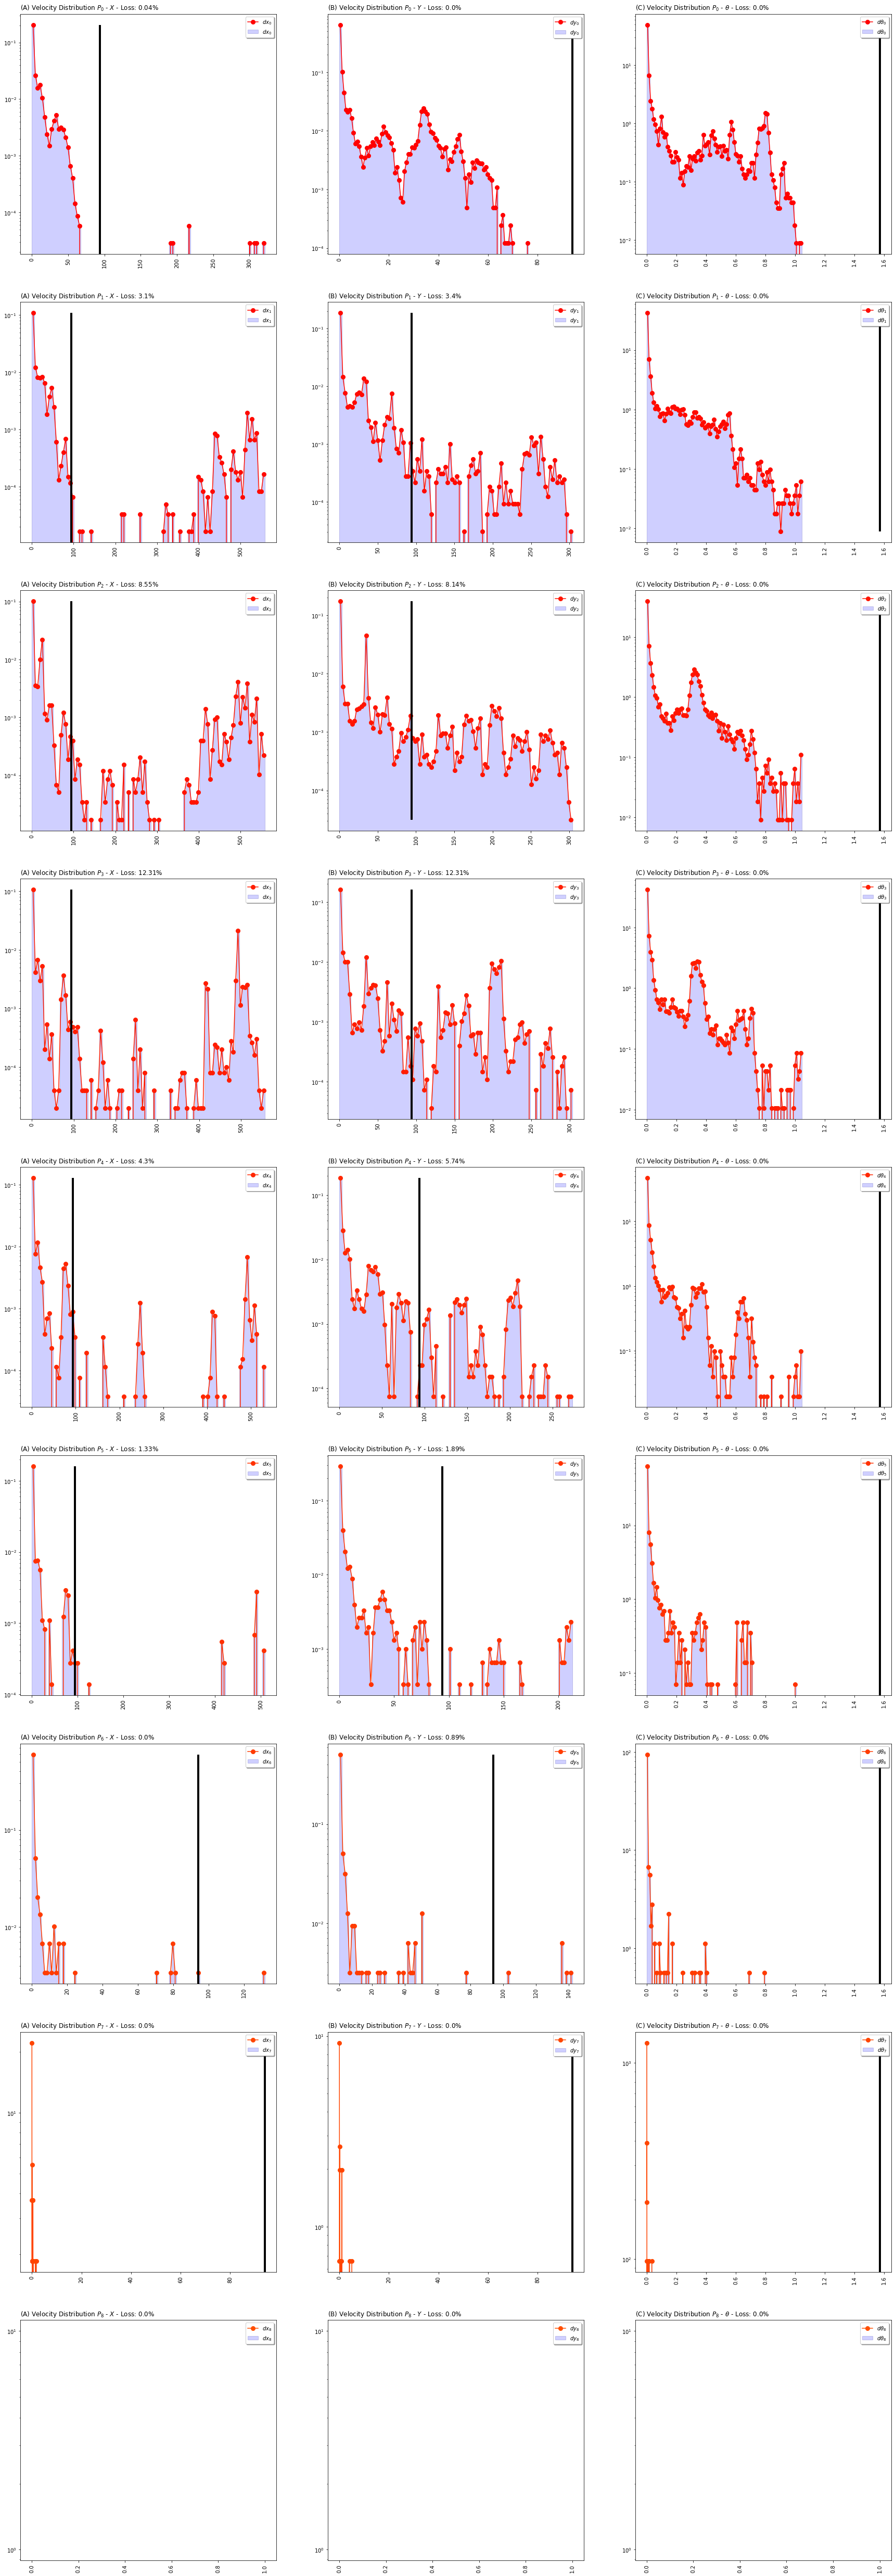

In [11]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [12]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,740
1,3,4266
2,4,16616
3,5,17160
4,6,7236
5,7,1358
6,8,240
7,9,9


## Clustering frames

In [13]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 40.32489148704302 



In [14]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [15]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,1.152756
1,2,False,True,False,0.014698
2,2,True,True,False,0.386352
3,3,False,False,False,7.542257
4,3,False,True,False,0.170079
5,3,True,False,False,0.071391
6,3,True,True,False,1.173753
7,4,False,False,False,32.041995
8,4,False,True,False,0.340157
9,4,True,False,False,0.268766


In [16]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 27.776077469749982 
	- Angle: 40.32489148704302 



In [17]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.006938822713079681%
Final loss data X-axis: 4.480166531745114%
Final loss data Y-axis: 7.561003816352493%
Final loss data Angle : 1.912802127905632%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.002313
1,3,True,False,True,0.002313
2,3,True,True,True,0.002313
3,4,False,False,False,0.302995
4,4,False,False,True,3.069273
5,4,False,True,False,0.067075
6,4,False,True,True,1.038510
7,4,True,False,False,0.791026
8,4,True,False,True,3.393084
9,4,True,True,False,0.749393


In [18]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 27.776077469749982 
	- Angle: 40.32489148704302 



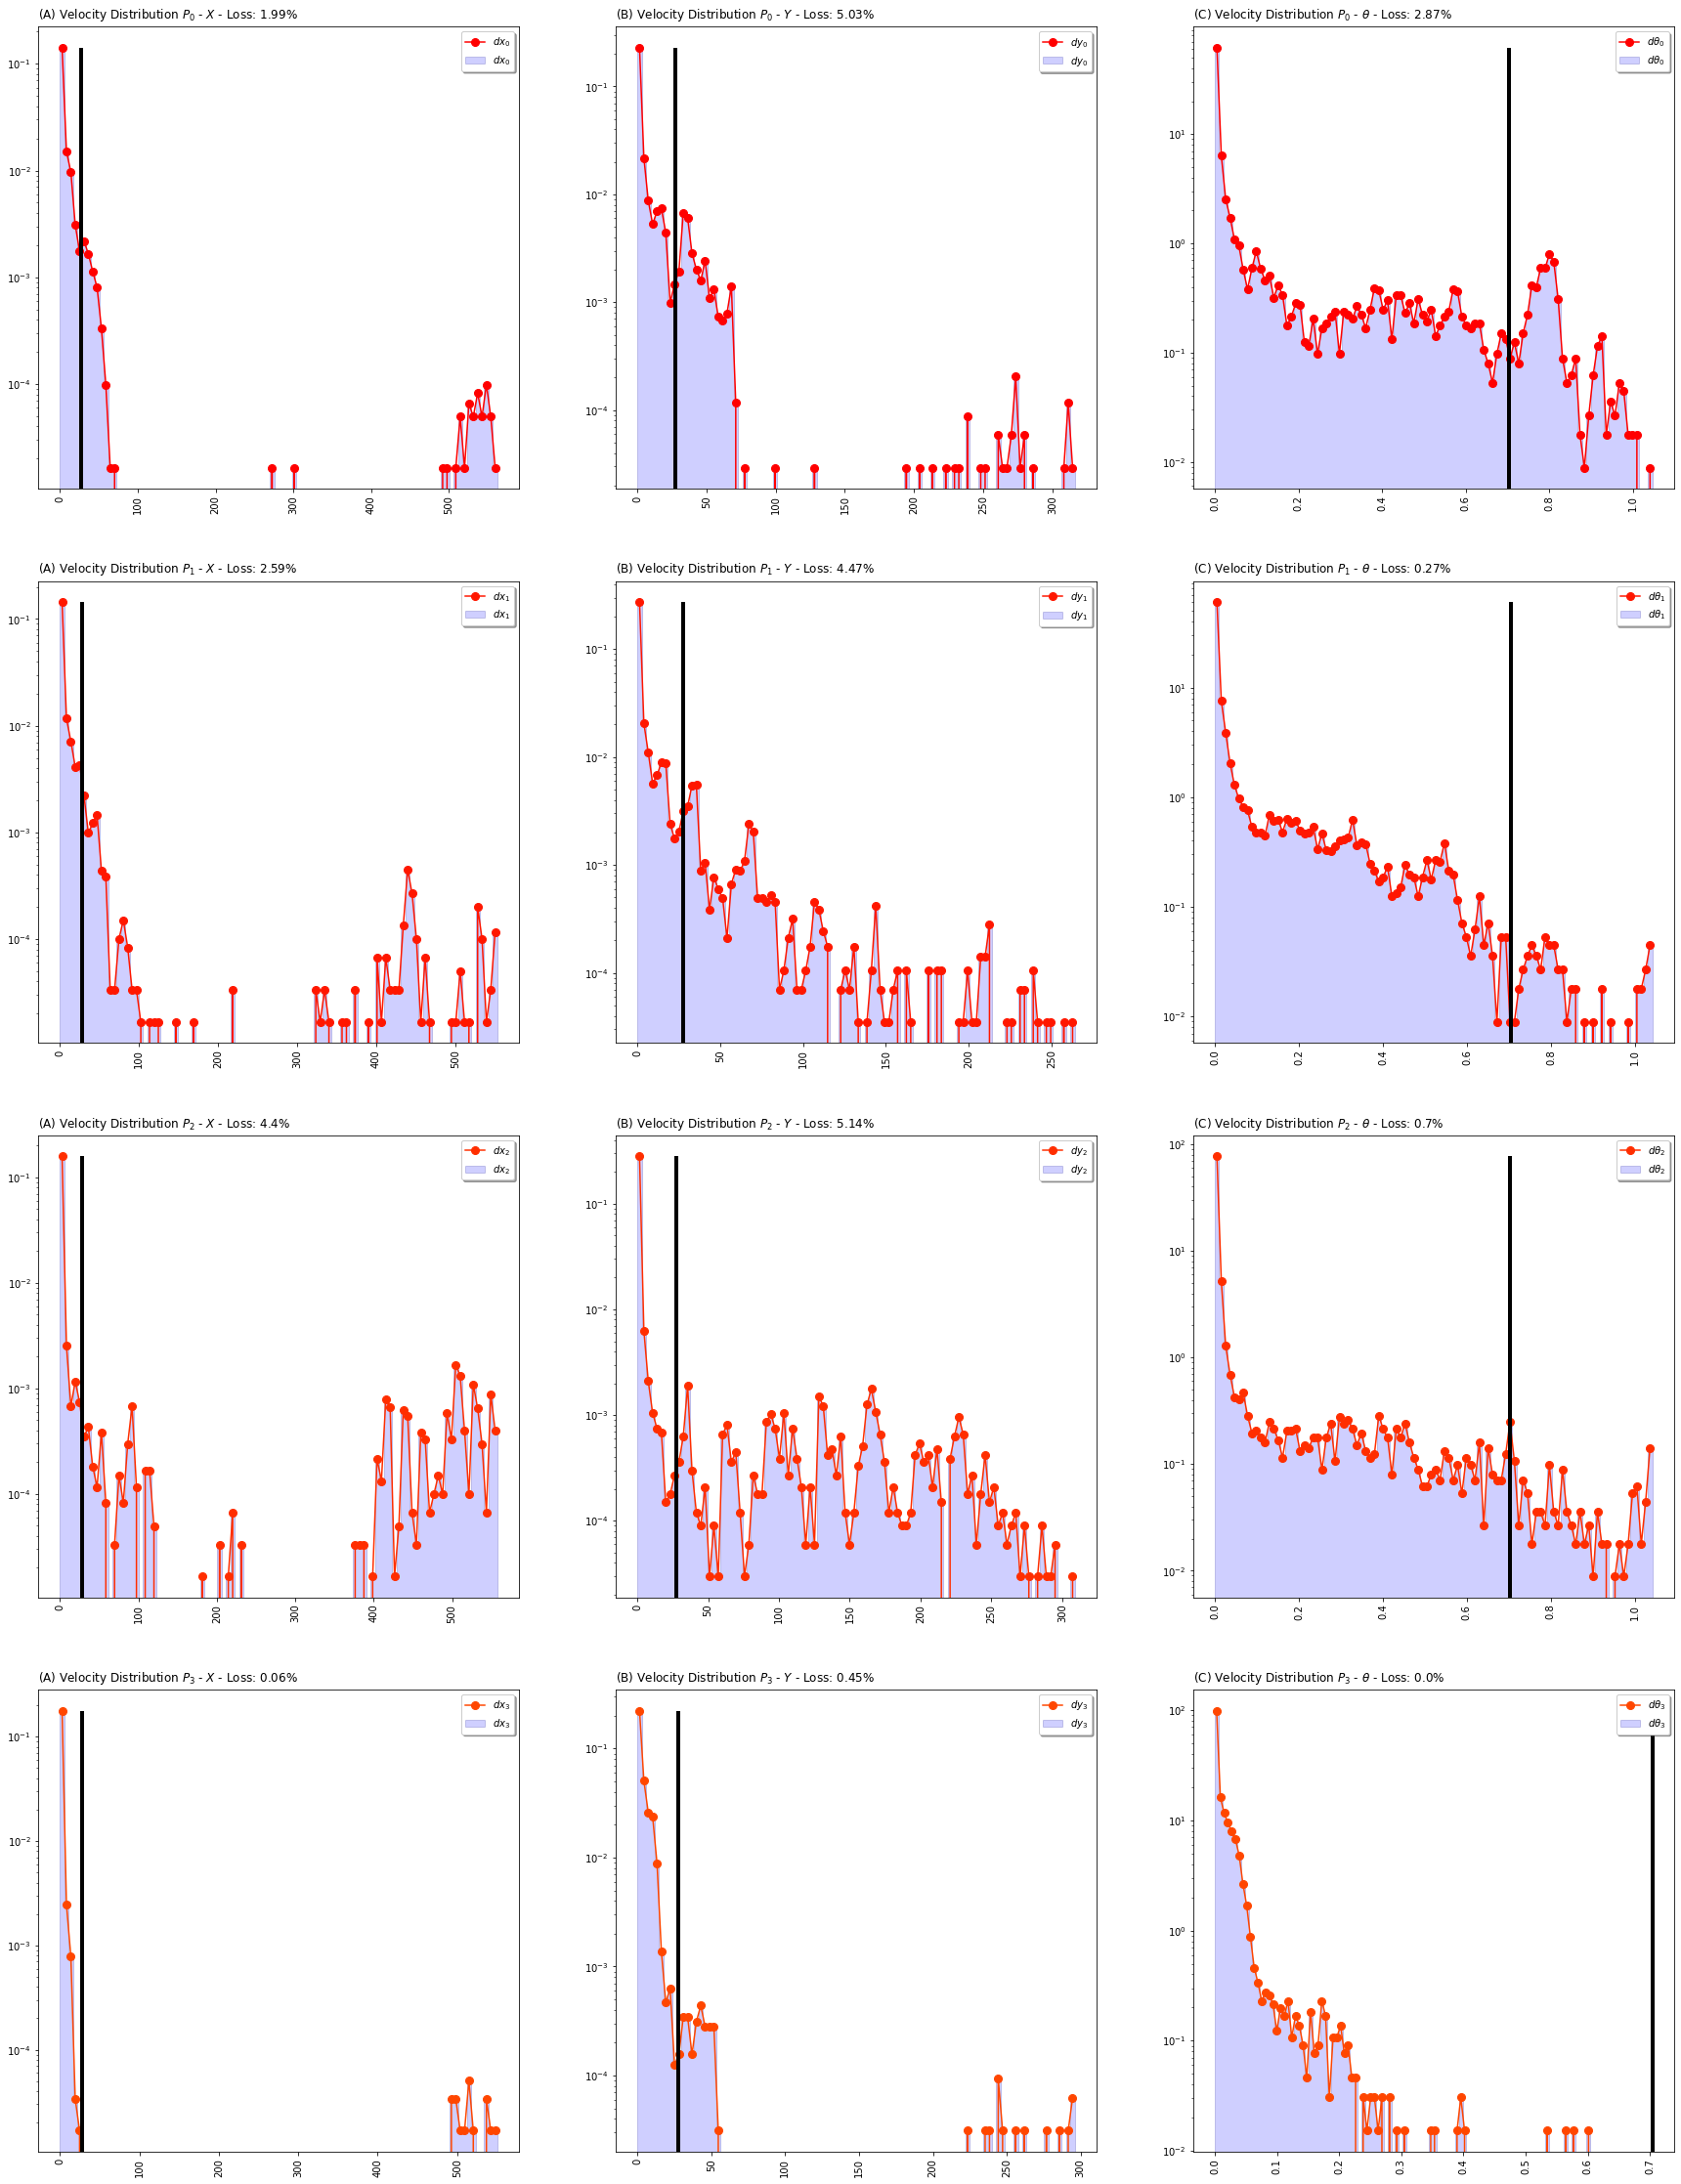

In [19]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [20]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [21]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
4154,1,0,71.000000,180.000000,75.018802,167.453360,NaN,60.841087,180.036849,NaN,60.841087,180.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
8308,2,0,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4,NaN,NaN,NaN,NaN,False,False,False
12462,3,0,1688.654083,946.185121,1688.350248,926.874967,NaN,1688.654083,946.185121,NaN,1688.654083,946.185121,-0.328264,6331.0,284.882246,77.154991,0.962627,4,NaN,NaN,NaN,NaN,False,False,False
16616,0,3,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4,3.0,-4.736952e-15,0.000000,0.0,False,False,False
16617,1,3,84.410082,179.543535,89.090484,174.551128,NaN,81.023778,179.555819,NaN,81.023778,179.555819,-0.038240,10855.0,422.210146,191.098291,0.891706,4,3.0,4.470027e+00,-0.152155,0.0,False,False,False
16618,2,3,110.841087,361.036849,125.018802,357.453360,NaN,110.841087,361.036849,NaN,110.841087,361.036849,-0.038240,10855.0,422.210146,191.098291,0.891706,4,3.0,-4.736952e-15,0.000000,0.0,False,False,False
16619,3,3,1689.472614,944.918401,1689.561211,925.735526,NaN,1689.472614,944.918401,NaN,1689.472614,944.918401,-0.328264,6331.0,284.882246,77.154991,0.962627,4,3.0,2.728437e-01,-0.422240,0.0,False,False,False
16620,0,6,110.841087,61.000000,125.018802,47.000000,NaN,110.841087,61.000000,NaN,110.841087,61.000000,1.315672,10855.0,422.210146,191.098291,0.891706,4,3.0,0.000000e+00,0.000000,0.0,False,False,False
16621,1,6,95.824110,191.526365,104.720026,181.770438,NaN,94.130958,191.532506,NaN,94.130958,191.532506,-0.038240,10855.0,422.210146,191.098291,0.891706,4,3.0,3.804676e+00,3.994276,0.0,False,False,False


## Visualize final data

In [22]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


In [23]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/4n_0m_4f_230330_2_c.zip'